In [1]:
# import tsv file and convert to json
import csv
import json
import os
import numpy as np

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import matplotlib.pyplot as plt

In [3]:
# visualise nlp drive usage
data = {
    "./annotations": "47M ",
    "./datasets": "154G",
    "./gsk": "1.1G",
    "./ck639": "148M",
    "./adtsakal": "373G",
    "./LLMs": "1.3T",
    "./gsk53": "6.0G",
    "./ahills": "1.3T",
    "./tt003": "302G",
    "./jsong": "33G",
    "./ia180": "7.9G",
    "./jchim": "331G",
    "./misc": "1.9M",
    ".": "3.8T",
}

total_used_space = "3.8T"
total_space = "4.0T"

In [36]:
def convert_to_bytes(size_str):
    """Convert size string to bytes."""
    size_str = size_str.strip()
    if size_str.endswith("G"):
        return float(size_str[:-1]) * 1024**3
    elif size_str.endswith("M"):
        return float(size_str[:-1]) * 1024**2
    elif size_str.endswith("K"):
        return float(size_str[:-1]) * 1024
    elif size_str.endswith("T"):
        return float(size_str[:-1]) * 1024**4
    else:
        return float(size_str)

def convert_to_size_str(size_bytes):
    """Convert bytes to a human-readable size string."""
    for unit in ["", "K", "M", "G", "T"]:
        if size_bytes < 1024:
            return f"{size_bytes:.1f}{unit}"
        size_bytes /= 1024
    return f"{size_bytes:.1f}T"  # Should not reach here for normal sizes

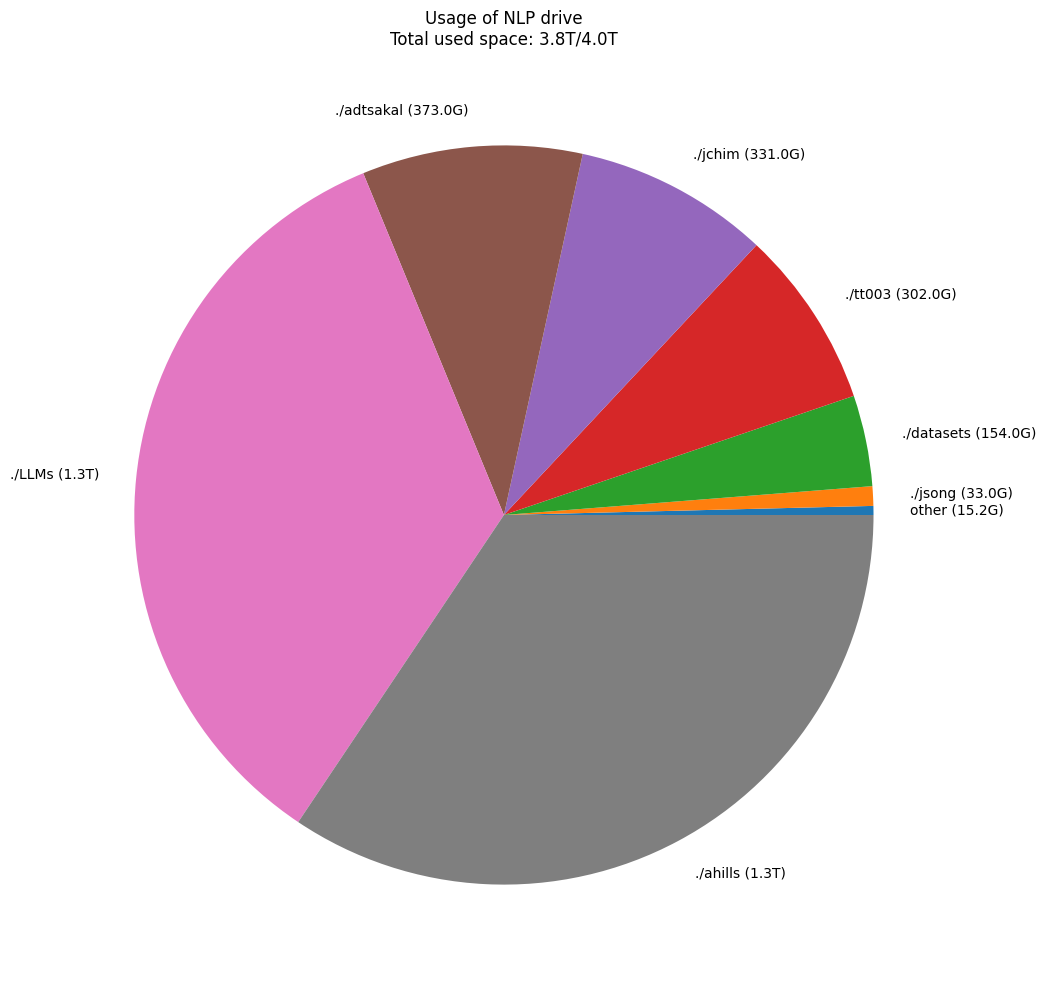

In [45]:
sizes = [convert_to_bytes(i) for i in data.values()]
sorted_indices = np.argsort(sizes)
sizes = np.array(sizes)[sorted_indices][:-1]

# sum first 6 elements
sizes = np.concatenate(([np.sum(sizes[:6])], sizes[6:]))

labels = list(data.keys())
labels = np.array(labels)[sorted_indices][:-1]

# label first 6 elements as "other"
labels = np.concatenate((["other"], labels[6:]))

labels = [f"{label} ({convert_to_size_str(size)})" for label, size in zip(labels, sizes)]

fig, ax = plt.subplots(figsize=(12, 12))
ax.pie(sizes, labels=labels)
plt.title(f"Usage of NLP drive\nTotal used space: {total_used_space}/{total_space}")
plt.show()

In [4]:
# generate sample data
all_data = []
data_per_month = []
months = ["31", "28", "31", "30", "31", "30", "31", "31", "30", "31", "30", "31"]
year = ["2018", "2019"]

for y in year:
    for i in range(12):
        monthly_posts = []
        for j in range(int(months[i])):
            random_int = np.random.randint(20)
            if random_int < 18:
                posts = 0
            else:
                posts = random_int - 17
            all_data.append({
                "date": f"{y}-%02d-%02d" % (i+1, j+1),
                "posts": posts
            })
            monthly_posts.append(posts)
        
        data_per_month.append({
            "date": f"{y}-%02d-01" % (i+1),
            "posts": sum(monthly_posts)
        })


# save as json
with open("sampleData.json", "w") as f:
    json.dump(all_data, f, indent=4)

with open("sampleDataPerMonth.json", "w") as f:
    json.dump(data_per_month, f, indent=4)

In [5]:
'''
Convert tsv file to json file for react app
'''

tsv_file = "three_labels/majority/3/52568_104.tsv"
json_file = tsv_file.replace('.tsv', '.json')

def save_tsv_to_json(tsv_file, json_file):
    with open(tsv_file) as tsvfile:
        reader = csv.DictReader(tsvfile, dialect='excel-tab')
        rows = list(reader)

    # the column names messed up in the tsv, we need to shift everything over by one 
    column_names = list(rows[0].keys())

    corrected_rows = []
    for row in rows:
        corrected_row = {}
        for i in range(len(column_names)-1):
            corrected_row[column_names[i]] = row[column_names[i+1]]
        corrected_rows.append(corrected_row)


    # save correct rows to json
    with open(json_file, 'w') as jsonfile:
        json.dump(corrected_rows, jsonfile, indent=4)



# with open(json_file, 'w') as jsonfile:
#     json.dump(rows, jsonfile, indent=4)

In [6]:
'''
Convert summary csv file to json file for react app
'''

csv_file = "timeline_summarization_orders.csv"
json_file = csv_file.replace('.csv', '.json')

with open(csv_file) as csvfile:
    reader = csv.DictReader(csvfile)
    rows = list(reader)

# organise rows as dictionary where key is timeline id 

timeline_dict = {}
for row in rows:
    timeline_dict[row['tlid']] = row


# save timeline_dict to json
with open(json_file, 'w') as jsonfile:
    json.dump(timeline_dict, jsonfile, indent=4)

In [7]:
timelines = list(timeline_dict.keys())

# iterate through three_labels/majority directory and look for tsv files that have corresponding timeline id

# majority has subdirs 0,1,2,3,4

subdirs = ["0", "1", "2", "3", "4"]

for subdir in subdirs:
    for root, dirs, files in os.walk("three_labels/majority/"+subdir):
        for file in files:
            if file.endswith(".tsv"):
                tlid = file.split(".")[0]
                if tlid in timelines:
                    save_tsv_to_json(os.path.join(root,file), file.replace('.tsv', '.json'))